# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Transform Object Definition

For train data set we will use rotation and horizontol flip to increase data content to cover wider different figures

In [14]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(),
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])

For test data set we will only use resize,centercrop, to tensor and normalization transform

In [15]:
test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Importing image data using dataloader

In [16]:
root = 'CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
#we can just cast train root completely in imagefolder() paranthesis
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes # specify classes

In [17]:
#To display class names we can write 
class_names

['CAT', 'DOG']

In [18]:
len(train_data)

18743

In [19]:
len(test_data)

6251

# Displaying first batch of the image

In [20]:
for i,(images,labels) in enumerate(train_loader):
    break

In [21]:
images.shape

torch.Size([10, 3, 224, 224])

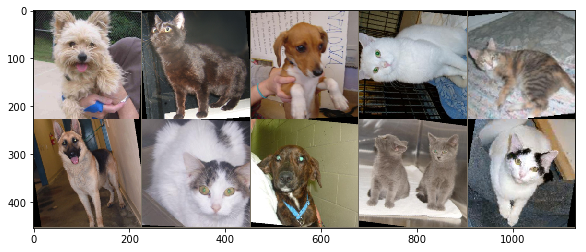

In [22]:
im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [3]:
AlexNetmodel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\eugur/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
100.0%


In [25]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [4]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [8]:
torch.manual_seed(42)

AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim=1))

In [11]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(),lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 1

#Limits on numbers of batches if you want train faster(Not mandatory)
max_trn_batch = 800 # batch 10 image --> 8000 images total
max_tst_batch = 300 # batch 10 image --> 3000 images total


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
        #optinal limit number of batches
        if b == max_trn_batch:
            break
        b = b + 1
        
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr = trn_corr + batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print('Epoch:  {} Loss:  {} Accuracy:  {}'.format(i,loss,trn_corr.item()*100/(10*b)))
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    #test set
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            #Optional
            if b==max_tst_batch:
                break
            y_val = AlexNetmodel(X_test)
            predicted = torch.max(y_val.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
    
total_time = time.time() - start_time
print(f'Total Time: {total_time/60}) minutes')

Epoch:  0 Loss:  0.35453271865844727 Accuracy:  94.6
Epoch:  0 Loss:  0.0003114354913122952 Accuracy:  94.25
Epoch:  0 Loss:  0.35240063071250916 Accuracy:  94.23333333333333
Epoch:  0 Loss:  0.004099384881556034 Accuracy:  93.9875
Total Time: 6.842555483182271) minutes
